In [1]:
import numpy as np
import pandas as pd

import json

In [2]:
json_file_path = "users_08.11.2022.json"

with open(json_file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

In [3]:
psycho_defense = np.zeros([1, 10], dtype=np.int64)

# weight = np.array([13, 14, 10, 13, 10, 12, 13, 12]) c косяком в посчетах
weight = np.array([13, 14, 10, 12, 10, 12, 13, 13]) # исправил и пересчитал

for ind in data:
    if ind["created_at"] >= 1658350800000:     
        for res in ind["results"]:
            if res["test_short_name"] == "psycho_defense":
                temp = np.zeros([1, 10], dtype=np.double)
                temp[0][0] = ind["vk_id"]
                temp[0][1] = res["completion_date"]                
                j=2
                for aspect in res["result"][0].values():
                    temp[0][j] = aspect/weight[j-2]*100
                    # temp[0][j] = aspect
                    j+=1

                psycho_defense = np.concatenate((psycho_defense, temp), axis=0)

# names = ["vk_id", "u_time", "Отрицание", "Регрессия", "Компенсация", "Рационализация", "Гиперкомпенсация", "Вытеснение", "Проекция", "Замещение"]
names = ["vk_id", "u_time", "PD1", "PD2", "PD3", "PD4", "PD5", "PD6", "PD7", "PD8"]
df = pd.DataFrame(psycho_defense, columns=names)
df.drop ([0], axis = 0, inplace = True)

df_pd = df.sort_values(['vk_id', 'u_time'], ascending=[True, True]).reset_index(drop=True)

l2d = []

for i in range(df_pd.shape[0]-1):
    if df_pd.at[i, 'vk_id'] == df_pd.at[i+1, 'vk_id']:
        l2d.append(i)

# print(l2d)

df_pd.drop(l2d, axis = 0, inplace = True)
df_pd.drop(["u_time"], axis = 1, inplace = True)

In [5]:
print(df_pd.max())

vk_id    760292908.0
PD1             13.0
PD2             14.0
PD3             10.0
PD4             13.0
PD5             10.0
PD6             12.0
PD7             13.0
PD8             12.0
dtype: float64


In [59]:
import cv2, math
import pandas as pd

def colourness(df_rgb):
    rg = (df_rgb["R"].values.astype(int) - df_rgb["B"].values.astype(int))
    yb = ((df_rgb["R"].values.astype(int) + df_rgb["G"].values.astype(int))/2 - df_rgb["B"].values.astype(int))
    m_rg = rg.mean()
    m_yb = yb.mean()
    var_rg = rg.var()
    var_yb = yb.var()
    m_rgyb = math.sqrt(m_rg**2 + m_yb**2)
    var_rgyb = math.sqrt(var_rg**2 + var_yb**2)
    return var_rgyb + 0.3*m_rgyb
    

def colour_stats(filepath_img):
    
    image = cv2.imread(filepath_img)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rgb = image_rgb.transpose(2,0,1).reshape(3,-1)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    image_hsv = image_hsv.transpose(2,0,1).reshape(3,-1)
    print(image_hsv.shape)
    df_rgb = pd.DataFrame(image_rgb.T, columns=["R", "G", "B"])
    df_hsv = pd.DataFrame(image_hsv.T, columns=["H", "S", "V"])

    stat_list = [colourness(df_rgb)]

    rgb_low = ((df_rgb[df_rgb <= 85].count())/df_rgb.shape[0]).values.tolist()                              # RGB низкие
    rgb_mid = ((df_rgb[(df_rgb > 85) & (df_rgb <= 170)].count())/df_rgb.shape[0]).values.tolist()           # RGB средние
    rgb_high = ((df_rgb[df_rgb > 170].count())/df_rgb.shape[0]).values.tolist()                             # RGB высокие

    stat_list += rgb_low + rgb_mid + rgb_high

    s_low = ((df_hsv['S'][df_hsv['S'] <= 85]).count())/df_hsv.shape[0]                                      # S низкие    
    s_mid = ((df_hsv['S'][(df_hsv['S'] > 85) & (df_hsv['S'] <= 170)]).count())/df_hsv.shape[0]              # S средние
    s_high = ((df_hsv['S'][df_hsv['S'] > 170]).count())/df_hsv.shape[0]                                     # S высокие

    stat_list += [s_low, s_mid, s_high]

    v_black = (df_hsv['V'][df_hsv['V'] <= 25].count())/df_hsv.shape[0]                                      # V низкие
    v_shadow = (df_hsv['V'][(df_hsv['V'] > 25) & (df_hsv['V'] <= 89)].count())/df_hsv.shape[0]              # V средние
    v_expose = (df_hsv['V'][(df_hsv['V'] > 89) & (df_hsv['V'] <= 166)].count())/df_hsv.shape[0]             # V средние
    v_highlight = (df_hsv['V'][(df_hsv['V'] > 166) & (df_hsv['V'] <= 230)].count())/df_hsv.shape[0]         # V средние
    v_whites = (df_hsv['V'][df_hsv['V'] > 230].count())/df_hsv.shape[0]                                     # V высокие

    stat_list += [v_black, v_shadow, v_expose, v_highlight, v_whites]

    h_red = df_hsv['H'][(df_hsv['H'] <= 15) | (df_hsv['H'] > 165)].count()/df_hsv.shape[0]                  # красный 
    h_yellow = df_hsv['H'][(df_hsv['H'] <= 45) & (df_hsv['H'] > 15)].count()/df_hsv.shape[0]                # желтый
    h_green = df_hsv['H'][(df_hsv['H'] <= 75) & (df_hsv['H'] > 45)].count()/df_hsv.shape[0]                 # зеленый
    h_blue = df_hsv['H'][(df_hsv['H'] <= 105) & (df_hsv['H'] > 75)].count()/df_hsv.shape[0]                 # голубой
    h_marin = df_hsv['H'][(df_hsv['H'] <= 135) & (df_hsv['H'] > 105)].count()/df_hsv.shape[0]               # синий
    h_purpure = df_hsv['H'][(df_hsv['H'] <= 165) & (df_hsv['H'] > 135)].count()/df_hsv.shape[0]             # фиолетовый

    stat_list += [h_red, h_yellow, h_green, h_blue, h_marin, h_purpure]

    return stat_list

# i = 4821238
# filepath_img = f'photos\img\photosid{i}.jpg'

# stats = colour_stats(filepath_img)
# print(stats)

In [60]:
print(colour_stats("my_photo.jpg"))

(3, 2795520)
[830.3043387396392, 0.5268264938186813, 0.5520028474130036, 0.506357672275641, 0.2644717261904762, 0.2692493704212454, 0.3259386446886447, 0.2087017799908425, 0.1787477821657509, 0.16770368303571428, 0.6466528588598901, 0.32769395318223443, 0.025653187957875457, 0.1253967061584249, 0.3608788347069597, 0.28161308092948717, 0.21078797504578756, 0.02132340315934066, 0.22151263450091574, 0.08209921588827838, 0.02274925595238095, 0.09108716804029304, 0.5169807406135531, 0.06557098500457875]


In [94]:
import cv2
import mtcnn
import numpy as np
import pandas as pd

detector = mtcnn.MTCNN()

def apply_yolo_object_detection(image_to_process):

    net = cv2.dnn.readNetFromDarknet("Resources/yolov4-tiny.cfg",
                                    "Resources/yolov4-tiny.weights")
    layer_names = net.getLayerNames()
    out_layers_indexes = net.getUnconnectedOutLayers()
    out_layers = [layer_names[index - 1] for index in out_layers_indexes]

    # Loading from a file of object classes that YOLO can detect
    with open("Resources/coco.names.txt") as file:
        classes = file.read().split("\n")

    look_for = ["person"]

    # Delete spaces
    list_look_for = []
    for look in look_for:
        list_look_for.append(look.strip())

    classes_to_look_for = list_look_for

    height, width, _ = image_to_process.shape
    blob = cv2.dnn.blobFromImage(image_to_process, 1 / 255, (608, 608),
                                 (0, 0, 0), swapRB=True, crop=False)
    net.setInput(blob)
    outs = net.forward(out_layers)
    class_indexes, class_scores, boxes = ([] for i in range(3))
    objects_count = 0

    # Starting a search for objects in an image
    for out in outs:
        for obj in out:
            scores = obj[5:]
            class_index = np.argmax(scores)
            class_score = scores[class_index]
            # 
            if class_score > 0.55:
                # print(class_index, class_score)
                center_x = int(obj[0] * width)
                center_y = int(obj[1] * height)
                obj_width = int(obj[2] * width)
                obj_height = int(obj[3] * height)
                box = [center_x - obj_width // 2, center_y - obj_height // 2,
                       obj_width, obj_height]
                boxes.append(box)
                class_indexes.append(class_index)
                class_scores.append(float(class_score))

    # Selection
    chosen_boxes = cv2.dnn.NMSBoxes(boxes, class_scores, 0.0, 0.4)
    for box_index in chosen_boxes:
        box_index = box_index
        box = boxes[box_index]
        class_index = class_indexes[box_index]

        # For debugging, we draw objects included in the desired classes
        if classes[class_index] in classes_to_look_for:
            objects_count += 1
    
    return objects_count




df_photo_LP = pd.read_csv('1.PD-BF-T_08.11.2022_nna.csv', delimiter=',')
df_photo_LP["vk_id"] = df_photo_LP["vk_id"].astype(int).values

persons = []

for i in df_photo_LP["vk_id"]:
    person_num_set = []

    image_path = f"photos\img\PD-BF-T\photosid{i}.jpg"

    if(not os.path.exists(image_path)):
        persons.append([0, -1, -1] + [0 for i in range(24)]) 
        continue

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # количество человек на фото
    person_num = apply_yolo_object_detection(image)

    # количество лиц на фото
    faces = detector.detect_faces(image)
    mtcnn_num = len(faces)
    person_num_set += [1, person_num, mtcnn_num]

    # цветовые характеристики
    stats = colour_stats(image_path)
    person_num_set += stats

    persons.append(person_num_set)

1/1 [==============================] - 0s 66ms/step


In [95]:
df_colour = pd.DataFrame(persons, columns = ["img_exist", "person_count", "face_count", "colourness", "r_low" , "g_low", "b_low", "r_mid", "g_mid", "b_mid", "r_high", "g_high", "b_high", "s_low", "s_mid", "s_high", "v_black", "v_shadow", "v_expose", "v_highlight", "v_whites", "h_red", "h_yellow", "h_green", "h_blue", "h_marin", "h_purpure"])
df_photo_LP = df_photo_LP.join(df_colour)

df_photo_LP_crop = df_photo_LP[df_photo_LP["img_exist"]==1]
df_photo_LP_crop.drop("img_exist", axis=1, inplace=True)

C:\Users\TICS lab\AppData\Local\Temp\ipykernel_1096\2863299867.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_photo_LP_crop.drop("img_exist", axis=1, inplace=True)


In [96]:
from datetime import datetime
from dateutil.relativedelta import relativedelta


df_ui = pd.read_csv('photos\\users_info_0.csv', delimiter=',')
# df_nna = pd.read_csv('all_test_08.11.2022_res_notna_v3.csv', delimiter=',')
df_nna = df_photo_LP_crop

df_ui = df_ui[df_ui["id"].isin(df_nna["vk_id"])]
df_ui["sex"] -= 1

now = datetime.now()
date = df_ui["bdate"].astype(str).values
age = []

for i in date:
    if i.count(".") > 1:
        age.append(relativedelta(now, datetime.strptime(i, r'%d.%m.%Y')).years)
    else:
        age.append(-1)

df_nna["age"] = age
df_nna["sex"] = df_ui["sex"].values
# df_nna["is_closed"] = df_ui["is_closed"].values

df_photo_LP_crop = df_nna

df_photo_LP_crop.to_csv('1.1.PD-BF-T_08.11.2022_nna_image.csv', encoding='utf-8', index = False)

C:\Users\TICS lab\AppData\Local\Temp\ipykernel_1096\2173018176.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nna["age"] = age
C:\Users\TICS lab\AppData\Local\Temp\ipykernel_1096\2173018176.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nna["sex"] = df_ui["sex"].values


In [60]:
import cv2
import mtcnn

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
# import face_recognition as fr



# def run_detector(detector, img):

#   converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  
#   result = detector(converted_img)
#   result = {key:value.numpy() for key,value in result.items()}

#   df = pd.DataFrame(result["detection_class_entities"], columns=["classes"])
#   df['score'] = result["detection_scores"]

#   df = df[df["score"] > 0.5]
#   if df.shape[0] == 0:
#     return(0)
#   else:
#     return(df[df["classes"] == b'Human face'].groupby('classes').count().values[0][0])

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# df_nna = pd.read_csv('all_test_08.11.2022_res_notna_rang.csv', delimiter=',')
df_nna = df_lp_ex

persons = []

for i in df_nna["vk_id"]:

    person_num_set = []
    
    filepath_img = f'photos\img\photosid{i}.jpg'
    
    if(not os.path.exists(filepath_img)):
        persons.append([0, -1, -1] + [0 for i in range(24)]) 
        continue

    im = cv2.imread(filepath_img)
    img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    outputs = predictor(im)
    # print(outputs["instances"].scores.tolist())
    df = pd.DataFrame(outputs["instances"].pred_classes.tolist(), columns=["classes"])
    df['score'] = outputs["instances"].scores.tolist()

    df = df[df["score"] > 0.9]
    # df.groupby("classes").count()
    if not len(df[df["classes"] == 0].groupby('classes').count().values) == 0:
        person_num = df[df["classes"] == 0].groupby('classes').count().values[0][0]
        # image = fr.load_image_file(filepath_img)
        # fr_num = len(fr.face_locations(img))
        faces = detector.detect_faces(img)
        mtcnn_num = len(faces)
        # tfh_num = run_detector(detector, im)
        person_num_set += [1, person_num, mtcnn_num]
    else:
        person_num_set += [1, 0, 0]

    stats = colour_stats(filepath_img)
    person_num_set += stats

    persons.append(person_num_set)

NameError: name 'get_cfg' is not defined

In [ ]:
# df_nna = pd.read_csv('all_test_08.11.2022_res_full_notna_v3.csv', delimiter=',')
df_colour = pd.DataFrame(persons, columns = ["ing_exist", "person_count", "face_count", "colourness", "r_low" , "g_low", "b_low", "r_mid", "g_mid", "b_mid", "r_high", "g_high", "b_high", "s_low", "s_mid", "s_high", "v_black", "v_shadow", "v_expose", "v_highlight", "v_whites", "h_red", "h_yellow", "h_green", "h_blue", "h_marin", "h_purpure"])
df_nna = df_nna.join(df_colour)
# df_nna.drop(['is_closed'], axis=1, inplace=True)
# df_nna.to_csv('all_test_08.11.2022_res_full_notna_v4.csv', encoding='utf-8', index = False)

In [52]:
columns = ["ing_exist", "person_count", "face_count", "colourness", "r_low" , "g_low", "b_low", "r_mid", "g_mid", "b_mid", "r_high", "g_high", "b_high", "s_low", "s_mid", "s_high", "v_black", "v_shadow", "v_expose", "v_highlight", "v_whites", "h_red", "h_yellow", "h_green", "h_blue", "h_marin", "h_purpure"]
len(columns)

27

In [2]:
import cv2
import imutils

hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
   
# Reading the Image
image = cv2.imread('photos\img\LP\photosid393498466.jpg')

(regions, _) = hog.detectMultiScale(image, 
                                    winStride=(4, 4),
                                    padding=(4, 4),
                                    scale=1.05)

In [23]:
import pandas as pd

df_udk = pd.read_csv('udk_data.csv', delimiter=',')
df_data = pd.read_csv('photos/users_info_0.csv', delimiter=',')

df_udk["sex"] = df_data[df_data["id"].isin(df_udk["vk_id"])]["sex"].values

df_udk.loc[(df_udk["sex"] == 2), "sex"] = -1
df_udk_sex = df_udk[["vk_id", "sex"]]

df_udk_sex.to_csv('udk_data_sex.csv', encoding='utf-8', index = False)

In [54]:
import pandas as pd

from datetime import datetime
from dateutil.relativedelta import relativedelta


df_ui = pd.read_csv('photos\\users_info_0.csv', delimiter=',')
# df_nna = pd.read_csv('all_test_08.11.2022_res_notna_v3.csv', delimiter=',')
df_nna = df_lp_ex

df_ui = df_ui[df_ui["id"].isin(df_nna["vk_id"])]
df_ui["sex"] -= 1

now = datetime.now()
date = df_ui["bdate"].astype(str).values
age = []

for i in date:
    if i.count(".") > 1:
        age.append(relativedelta(now, datetime.strptime(i, r'%d.%m.%Y')).years)
    else:
        age.append(-1)

df_nna["age"] = age
df_nna["sex"] = df_ui["sex"].values
# df_nna["is_closed"] = df_ui["is_closed"].values

df_lp_ex = df_nna
# df_lp_ex.drop("is_closed", axis=1, inplace=True)

# df_nna.to_csv('all_test_08.11.2022_res_full_notna_v3.csv', encoding='utf-8', index = False)

C:\Users\TICS lab\AppData\Local\Temp\ipykernel_10320\2910443805.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nna["age"] = age
C:\Users\TICS lab\AppData\Local\Temp\ipykernel_10320\2910443805.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nna["sex"] = df_ui["sex"].values


In [44]:
df_nna2 = pd.read_csv('all_test_08.11.2022_res_full_notna_v4.csv', delimiter=',')

In [21]:
# df_pd.to_csv('PD_2.csv', encoding='utf-8', index = False)

In [5]:
temperament = np.zeros([1, 6])

for ind in data:
    if ind["created_at"] >= 1658350800000:        
        for res in ind["results"]:
            if res["test_short_name"] == "temperament":
                temp = np.zeros([1, 6], dtype=np.double)
                temp[0][0] = ind["vk_id"]
                temp[0][1] = res["completion_date"]                
                j=2
                for aspect in res["result"][0].values():
                    temp[0][j] = aspect#/25
                    j+=1
                temperament = np.concatenate((temperament, temp), axis=0)


# names = ["vk_id", "u_time", "Экстраверсия", "Психотизм", "Нейротизм", "Искренность"]
names = ["vk_id", "u_time_t", "T1", "T2", "T3", "T4"]
df = pd.DataFrame(temperament, columns=names)
df.drop ([0], axis = 0, inplace = True)

df_t = df.sort_values(['vk_id', 'u_time_t'], ascending=[True, True]).reset_index(drop=True)

l2d = []

for i in range(df_t.shape[0]-1):
    if df_t.at[i, 'vk_id'] == df_t.at[i+1, 'vk_id']:
        l2d.append(i)

df_t.drop(l2d, axis = 0, inplace = True)
df_t.drop(["u_time_t"], axis = 1, inplace = True)

In [13]:
# df_t.to_csv('Temp_2.csv', encoding='utf-8', index = False)

In [6]:
big_five = np.zeros([1, 7])

for ind in data:
    if ind["created_at"] >= 1658350800000:        
        for res in ind["results"]:
            if res["test_short_name"] == "big_five":
                temp = np.zeros([1, 7], dtype=np.double)
                temp[0][0] = ind["vk_id"]
                temp[0][1] = res["completion_date"]                
                j=2
                for aspect in res["result"][0].values():
                    temp[0][j] = aspect
                    # temp[0][j] = (aspect-15)/60 # похоже не в обычной шкале а в процентах                    
                    j+=1                
                big_five = np.concatenate((big_five, temp), axis=0)

# names = ["vk_id", "u_time", "Экстраверсия–интроверсия", "Привязанность–обособленность", "Самоконтроль–импульсивность", "Эмоциональная_устойчивость–эмоциональная_неустойчивость", "Экспрессивность–практичность"]
names = ["vk_id", "u_time_bf", "BF1", "BF2", "BF3", "BF4", "BF5"]

df = pd.DataFrame(big_five, columns=names)
df.drop ([0], axis = 0, inplace = True)

df_bf = df.sort_values(['vk_id', 'u_time_bf'], ascending=[True, True]).reset_index(drop=True)

l2d = []

for i in range(df_bf.shape[0]-1):
    if df_bf.at[i, 'vk_id'] == df_bf.at[i+1, 'vk_id']:
        l2d.append(i)

df_bf.drop(l2d, axis = 0, inplace = True)
df_bf.drop(["u_time_bf"], axis = 1, inplace = True)

In [7]:
aak = df_bf["vk_id"].astype('int')
np.savetxt(r'BF.txt', aak.values, fmt='%d')

In [64]:
df_bf.to_csv('BF_08.11.2022.csv', encoding='utf-8', index = False)

In [11]:
leonhard_poll = np.zeros([1, 12])

for ind in data:
    if ind["created_at"] >= 1658350800000:        
        for res in ind["results"]:
            if res["test_short_name"] == "leonhard_poll":
                temp = np.zeros([1, 12], dtype=np.double)
                temp[0][0] = ind["vk_id"]
                temp[0][1] = res["completion_date"]                
                j=2
                for aspect in res["result"][0].values():
                    temp[0][j] = aspect
                    # temp[0][j] = aspect/24
                    j+=1                
                leonhard_poll = np.concatenate((leonhard_poll, temp), axis=0)

# names = ["vk_id", "u_time_lp", "Г-1", "Г-2", "Г-3", "Г-4", "Г-5", "Г-6", "Г-7", "Г-8", "Г-9", "Г-10"]
names = ["vk_id", "u_time_lp", "LP1", "LP2", "LP3", "LP4", "LP5", "LP6", "LP7", "LP8", "LP9", "LP10"]
df = pd.DataFrame(leonhard_poll, columns=names)
df.drop ([0], axis = 0, inplace = True)

df_lp = df.sort_values(['vk_id', 'u_time_lp'], ascending=[True, True]).reset_index(drop=True)

l2d = []

for i in range(df_lp.shape[0]-1):
    if df_lp.at[i, 'vk_id'] == df_lp.at[i+1, 'vk_id']:
        l2d.append(i)

df_lp.drop(l2d, axis = 0, inplace = True)
# df_lp.drop(["u_time_lp"], axis = 1, inplace = True)

In [12]:
for i, row in df_lp.iterrows():
    #==========================
    # LP
    for k in range(10):
        name = f'LP{k+1}'
        if row[name] < 8:
            df_lp[name][i] = 1
        elif row[name] > 12:
            df_lp[name][i] = 3
        else:
            df_lp[name][i] = 2

df_lp.to_csv('2.LP_08.11.2022-cat.csv', encoding='utf-8', index = False)

In [41]:
# weight = np.array([30, 39, 39, 39, 30, 39, 30, 30, 39, 30, 39, 30, 30, 30, 39 ,13])
weight = np.array([20, 26, 26, 26, 20, 26, 20, 20, 26, 20, 26, 20, 20, 20, 26 ,13])
cattell_poll = np.zeros([1, 18])

for ind in data:
    if ind["created_at"] >= 1658350800000:        
        for res in ind["results"]:
            if res["test_short_name"] == "cattell_poll":
                temp = np.zeros([1, 18], dtype=np.double)
                temp[0][0] = ind["vk_id"]
                temp[0][1] = res["completion_date"]                
                j=2
                for aspect in res["result"][0].values():
                    temp[0][j] = aspect
                    # temp[0][j] = aspect/weight[j-2]
                    j+=1                
                cattell_poll = np.concatenate((cattell_poll, temp), axis=0)

# names = ["vk_id", "u_time", "A", "C", "E", "F", "G", "H", "I", "L", "M", "N", "O", "Q1","Q2", "Q3", "Q4", "B"]
names = ["vk_id", "u_time_cp",'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CP7', 'CP8', 'CP9', 'CP10', 'CP11', 'CP12', 'CP13', 'CP14', 'CP15', 'CP16']  
df = pd.DataFrame(cattell_poll, columns=names)
df.drop ([0], axis = 0, inplace = True)

df_cp = df.sort_values(['vk_id', 'u_time_cp'], ascending=[True, True]).reset_index(drop=True)

l2d = []

for i in range(df_cp.shape[0]-1):
    if df_cp.at[i, 'vk_id'] == df_cp.at[i+1, 'vk_id']:
        l2d.append(i)

df_cp.drop(l2d, axis = 0, inplace = True)
# df_cp.drop(["u_time_cp"], axis = 1, inplace = True)

In [42]:
m={}
m['CP1'] = [6, 7, 8, 10, 11, 13, 15, 16, 18]
m['CP16'] = [4, 5, 6, 8, 9, 9, 10, 11, 12]
m['CP2'] = [7, 8, 10, 12, 14, 17, 19, 21, 22]
m['CP3'] = [6, 8, 10, 12, 15, 17, 19, 21, 23]
m['CP4'] = [4, 6, 8, 11, 14, 16, 18, 20, 23]
m['CP5'] = [5, 7, 8, 10, 12, 14, 16, 17, 19]
m['CP6'] = [3, 5, 7, 10, 13, 16, 19, 20, 22]
m['CP7'] = [5, 6, 8, 10, 12, 14, 16, 17, 19]
m['CP8'] = [6, 7, 8, 10, 11, 13, 15, 16, 17]
m['CP9'] = [7, 9, 11, 12, 14, 16, 18, 19, 20]
m['CP10'] = [3, 5, 6, 8, 9, 11, 12, 14, 16]
m['CP11'] = [5, 7, 8, 10, 14, 16, 18, 20, 22]
m['CP12'] = [6, 8, 9, 11, 13, 15, 17, 18, 19]
m['CP13'] = [4, 6, 7, 9, 11, 13, 15, 16, 18]
m['CP14'] = [4, 6, 7, 9, 11, 13, 14, 15, 17]
m['CP15'] = [6, 8, 10, 13, 16, 19, 21, 23, 25]

df_m = pd.DataFrame(m)

# Психологическая защита в проценты
# df_nna = pd.read_csv('all_test_08.11.2022_res_notna_rang.csv', delimiter=',')
# df_pd = df_pd[df_pd["vk_id"].isin(df_nna["vk_id"])]
# for i in range(8):
#     df_nna[f"PD{i+1}"] = [round(item) for item in df_pd[f"PD{i+1}"].values]

# Кеттел в стены
# df_cp = df_cp[df_cp["vk_id"].isin(df_nna["vk_id"])]

# for i in df_m:
#     j_ind = 0
#     for j in df_cp[i]:
#         print(j)
#         for k in range(df_m.shape[0]):
#             if j < df_m[i][k]:
#                 df_nna[i][j_ind] = k+1
#                 break
#         if j >= df_m[i][8]:
#             df_nna[i][j_ind] = 10     
        
#         j_ind += 1

for i, row in df_cp.iterrows():
    for j in df_m:
        for k in range(df_m.shape[0]):
            # print(row[j], df_m[j][k])
            if int(row[j]) < df_m[j][k]:
                df_cp[j][i] = k+1
                break
        if int(row[j]) >= df_m[j][8]:
            df_cp[j][i] = 10

df_cp.to_csv('3.CP_08.11.2022-sten.csv', encoding='utf-8', index = False)

# df_nna.max()
# df_nna.to_csv('all_test_08.11.2022_res_notna_v3.csv', encoding='utf-8', index = False)
  

In [10]:
df_pd.max()

vk_id    7.602929e+08
PD1      1.000000e+02
PD2      1.000000e+02
PD3      1.000000e+02
PD4      1.083333e+02
PD5      1.000000e+02
PD6      1.000000e+02
PD7      1.000000e+02
PD8      9.230769e+01
dtype: float64

In [76]:
weight = np.array([8, 5, 4, 3, 5, 3, 4, 5, 5, 4, 4, 3, 6, 4, 5, 3, 4, 4, 3, 4])
schwartz_poll = np.zeros([1, 22])

for ind in data:
    if ind["created_at"] >= 1658350800000:        
        for res in ind["results"]:
            if res["test_short_name"] == "schwartz_poll":
                temp = np.zeros([1, 22], dtype=np.double)
                temp[0][0] = ind["vk_id"]
                temp[0][1] = res["completion_date"]                
                j=2
                for aspect in res["result"][0].values():
                    temp[0][j] = aspect/weight[j-2]
                    j+=1
                temp10 = temp[0][2:12]
                temp20 = temp[0][12:]
                
                for i in range(10):
                    temp[0][np.argmax(temp10)+2] = -(i+1)*10
                    temp[0][np.argmax(temp20)+12] = -(i+1)*10
                temp[0][2:] /=-10
                schwartz_poll = np.concatenate((schwartz_poll, temp), axis=0)

# names = ["vk_id", "u_time_sp", "1Универсализм1", "2Безопасность1", "3Власть1", "4Гедонизм1", "5Самостоятельность1", "6Стимуляция1", "7Конформность1", "8Традиция1", "9Доброта1", "10Достижение1", 
# "11Самостоятельность2", "12Власть2", "13Универсализм2", "14Достижение2", "15Безопасность2", "16Стимуляция2", "17Конформность2", "18Традиция2", "19Гедонизм2", "20Доброта2"]
names = ["vk_id", "u_time_sp","SP1", "SP2", "SP3", "SP4", "SP5", "SP6", "SP7", "SP8", "SP9", "SP10", "SP11", "SP12", "SP13", "SP14", "SP15", "SP16", "SP17", "SP18", "SP19", "SP20"]
df = pd.DataFrame(schwartz_poll, columns=names)
df.drop ([0], axis = 0, inplace = True)


df_sp = df.sort_values(['vk_id', 'u_time_sp'], ascending=[True, True]).reset_index(drop=True)

l2d = []

for i in range(df_sp.shape[0]-1):
    if df_sp.at[i, 'vk_id'] == df_sp.at[i+1, 'vk_id']:
        l2d.append(i)

df_sp.drop(l2d, axis = 0, inplace = True)
# df_sp.drop(["u_time_sp"], axis = 1, inplace = True)

In [77]:
df_sp.to_csv('4.SP_08.11.2022-rang.csv', encoding='utf-8', index = False)

In [26]:
a = df_pd['vk_id'].to_numpy()
a = np.concatenate((a, df_bf['vk_id'].to_numpy()), axis=None)
a = np.concatenate((a, df_t['vk_id'].to_numpy()), axis=None)
# a = np.concatenate((a, df_cp['vk_id'].to_numpy()), axis=None)
# a = np.concatenate((a, df_lp['vk_id'].to_numpy()), axis=None)
# a = np.concatenate((a, df_sp['vk_id'].to_numpy()), axis=None)

a = np.unique(a)

res = pd.DataFrame(a, columns=['vk_id']).astype(int)

In [27]:
df_pd = df_pd.reset_index(drop=True)
df_bf = df_bf.reset_index(drop=True)
# df_cp = df_cp.reset_index(drop=True)
# df_lp = df_lp.reset_index(drop=True)
# df_sp = df_sp.reset_index(drop=True)
df_t = df_t.reset_index(drop=True)

In [29]:
na_pd = np.full([1, 8], np.nan)

for i in res["vk_id"]:
    if i in df_pd["vk_id"].unique():
        ind_v = df_pd[df_pd["vk_id"] == i].index.tolist()[0]
        
        na_pd = np.append(na_pd, [df_pd.iloc[ind_v].values[1:]], axis=0)
    else:
        na_pd = np.append(na_pd, np.full([1,8], np.nan), axis=0)

na_pd = np.delete(na_pd, 0, 0)

In [31]:
res['PD1'] = na_pd[:, 0] # Отрицание
res['PD2'] = na_pd[:, 1] # Регрессия
res['PD3'] = na_pd[:, 2] # Компенсация
res['PD4'] = na_pd[:, 3] # Рационализация
res['PD5'] = na_pd[:, 4] # Гиперкомпенсация
res['PD6'] = na_pd[:, 5] # Вытеснение
res['PD7'] = na_pd[:, 6] # Проекция
res['PD8'] = na_pd[:, 7] # Замещение
# res['u_time_pd'] = na_pd[:, 8] # Замещение

In [38]:
na_bf = np.full([1, 5], np.nan)

for i in res["vk_id"]:
    if i in df_bf["vk_id"].unique():
        ind_v = df_bf[df_bf["vk_id"] == i].index.tolist()[0]
        
        na_bf = np.append(na_bf, [df_bf.iloc[ind_v].values[1:]], axis=0)
    else:
        na_bf = np.append(na_bf, np.full([1,5], np.nan), axis=0)

na_bf = np.delete(na_bf, 0, 0)

In [39]:
res['BF1'] = na_bf[:, 0] # Экстраверсия–интроверсия
res['BF2'] = na_bf[:, 1] # Привязанность–обособленность
res['BF3'] = na_bf[:, 2] # Самоконтроль–импульсивность
res['BF4'] = na_bf[:, 3] # Эмоциональная_устойчивость–эмоциональная_неустойчивость
res['BF5'] = na_bf[:, 4] # Экспрессивность–практичность
# res['u_time_bf'] = na_bf[:, 5] # время

In [ ]:
na_cp = np.full([1, 16], np.nan)

for i in res["vk_id"]:
    if i in df_cp["vk_id"].unique():
        ind_v = df_cp[df_cp["vk_id"] == i].index.tolist()[0]
        
        na_cp = np.append(na_cp, [df_cp.iloc[ind_v].values[1:]], axis=0)
    else:
        na_cp = np.append(na_cp, np.full([1,16], np.nan), axis=0)

na_cp = np.delete(na_cp, 0, 0)

In [65]:
res['CP1'] = na_cp[:, 0]    # A
res['CP2'] = na_cp[:, 1]    # C
res['CP3'] = na_cp[:, 2]    # E
res['CP4'] = na_cp[:, 3]    # F
res['CP5'] = na_cp[:, 4]    # G
res['CP6'] = na_cp[:, 5]    # H
res['CP7'] = na_cp[:, 6]    # I
res['CP8'] = na_cp[:, 7]    # L
res['CP9'] = na_cp[:, 8]    # M
res['CP10'] = na_cp[:, 9]   # N
res['CP11'] = na_cp[:, 10]   # O
res['CP12'] = na_cp[:, 11]   # Q1
res['CP13'] = na_cp[:, 12]   # Q2
res['CP14'] = na_cp[:, 13]   # Q3
res['CP15'] = na_cp[:, 14]   # Q4
res['CP16'] = na_cp[:, 15]   # B

In [66]:
na_lp = np.full([1, 10], np.nan)

for i in res["vk_id"]:
    if i in df_lp["vk_id"].unique():
        ind_v = df_lp[df_lp["vk_id"] == i].index.tolist()[0]
        
        na_lp = np.append(na_lp, [df_lp.iloc[ind_v].values[1:]], axis=0)
    else:
        na_lp = np.append(na_lp, np.full([1,10], np.nan), axis=0)

na_lp = np.delete(na_lp, 0, 0)

In [67]:
res['LP1'] = na_lp[:, 0]    # Г-1
res['LP2'] = na_lp[:, 1]    # Г-2
res['LP3'] = na_lp[:, 2]    # Г-3
res['LP4'] = na_lp[:, 3]    # Г-4
res['LP5'] = na_lp[:, 4]    # Г-5
res['LP6'] = na_lp[:, 5]    # Г-6
res['LP7'] = na_lp[:, 6]    # Г-7
res['LP8'] = na_lp[:, 7]    # Г-8
res['LP9'] = na_lp[:, 8]    # Г-9
res['LP10'] = na_lp[:, 9]   # Г-10

In [48]:
na_sp = np.full([1, 20], np.nan)

for i in res["vk_id"]:
    if i in df_sp["vk_id"].unique():
        ind_v = df_sp[df_sp["vk_id"] == i].index.tolist()[0]
        
        na_sp = np.append(na_sp, [df_sp.iloc[ind_v].values[1:]], axis=0)
    else:
        na_sp = np.append(na_sp, np.full([1,20], np.nan), axis=0)

na_sp = np.delete(na_sp, 0, 0)

In [49]:
res['SP1'] = na_sp[:, 0]    # Г-1
res['SP2'] = na_sp[:, 1]    # Г-2
res['SP3'] = na_sp[:, 2]    # Г-3
res['SP4'] = na_sp[:, 3]    # Г-4
res['SP5'] = na_sp[:, 4]    # Г-5
res['SP6'] = na_sp[:, 5]    # Г-6
res['SP7'] = na_sp[:, 6]    # Г-7
res['SP8'] = na_sp[:, 7]    # Г-8
res['SP9'] = na_sp[:, 8]    # Г-9
res['SP10'] = na_sp[:, 9]   # Г-10
res['SP11'] = na_sp[:, 10]    # Г-1
res['SP12'] = na_sp[:, 11]    # Г-2
res['SP13'] = na_sp[:, 12]    # Г-3
res['SP14'] = na_sp[:, 13]    # Г-4
res['SP15'] = na_sp[:, 14]    # Г-5
res['SP16'] = na_sp[:, 15]    # Г-6
res['SP17'] = na_sp[:, 16]    # Г-7
res['SP18'] = na_sp[:, 17]    # Г-8
res['SP19'] = na_sp[:, 18]    # Г-9
res['SP20'] = na_sp[:, 19]   # Г-10

In [40]:
na_t = np.full([1, 4], np.nan)

for i in res["vk_id"]:
    if i in df_t["vk_id"].unique():
        ind_v = df_t[df_t["vk_id"] == i].index.tolist()[0]
        
        na_t = np.append(na_t, [df_t.iloc[ind_v].values[1:]], axis=0)
    else:
        na_t = np.append(na_t, np.full([1,4], np.nan), axis=0)

na_t = np.delete(na_t, 0, 0)

In [42]:
res['T1'] = na_t[:, 0]    # Экстраверсия
res['T2'] = na_t[:, 1]    # Психотизм
res['T3'] = na_t[:, 2]    # Нейротизм
res['T4'] = na_t[:, 3]    # Искренность
# res['u_time_t'] = na_t[:, 4] # время

In [55]:
# res.to_csv('all_test_08.11.2022_res_rang_exceptSP.csv', encoding='utf-8', index = False)
df_notna = res[res.isnull().any(1)==False]
# df_notna.to_csv('PD-BF-T_08.11.2022_typicalScore.csv', encoding='utf-8', index = False)

C:\Users\TICS lab\AppData\Local\Temp\ipykernel_6392\2002766310.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  df_notna = res[res.isnull().any(1)==False]


In [58]:
df_all = pd.read_csv('1.1.PD-BF-T_08.11.2022_nna_image.csv', delimiter=',')

df_notna = df_notna[df_notna["vk_id"].isin(df_all["vk_id"].values)]
df_notna.to_csv('PD-BF-T_08.11.2022_typicalScore.csv', encoding='utf-8', index = False)

In [116]:
from sklearn.preprocessing import StandardScaler as sc
from sklearn.compose import ColumnTransformer

# df_pd_cp = df_pd.drop(["vk_id"], axis = 1)
df_pd_cp = df_pd.copy()

df_pd_cp['PD1'] = (df_pd_cp['PD1'] - df_pd_cp['PD1'].mean()) / df_pd_cp['PD1'].std()
df_pd_cp['PD2'] = (df_pd_cp['PD2'] - df_pd_cp['PD2'].mean()) / df_pd_cp['PD2'].std()
df_pd_cp['PD3'] = (df_pd_cp['PD3'] - df_pd_cp['PD3'].mean()) / df_pd_cp['PD3'].std()
df_pd_cp['PD4'] = (df_pd_cp['PD4'] - df_pd_cp['PD4'].mean()) / df_pd_cp['PD4'].std()
df_pd_cp['PD5'] = (df_pd_cp['PD5'] - df_pd_cp['PD5'].mean()) / df_pd_cp['PD5'].std()
df_pd_cp['PD6'] = (df_pd_cp['PD6'] - df_pd_cp['PD6'].mean()) / df_pd_cp['PD6'].std()
df_pd_cp['PD7'] = (df_pd_cp['PD7'] - df_pd_cp['PD7'].mean()) / df_pd_cp['PD7'].std()
df_pd_cp['PD8'] = (df_pd_cp['PD8'] - df_pd_cp['PD8'].mean()) / df_pd_cp['PD8'].std()

# df_pd_cp[("PD1", "PD2", "PD3", "PD4", "PD5", "PD6", "PD7", "PD8")] = df_pd_cp[("PD1", "PD2", "PD3", "PD4", "PD5", "PD6", "PD7", "PD8")].apply(lambda x: sc().fit_transform(x))

col_names = ["PD1", "PD2", "PD3", "PD4", "PD5", "PD6", "PD7", "PD8"]
features = df_pd_cp[col_names]
scaler = sc().fit(features.values)
features = scaler.transform(features.values)

df_pd_cp[col_names] = features
print(df_pd_cp)

           vk_id       PD1       PD2       PD3       PD4       PD5       PD6  \
0          39270 -0.620944 -0.405104 -0.883506  0.547252 -1.217381  0.399491   
1          67784 -0.620944  0.885185 -0.411626 -1.303413 -0.194382 -0.850149   
2          88544  0.173931 -0.405104 -1.355386 -1.303413 -0.705882 -0.017055   
3         172615 -0.620944 -0.082532 -0.883506  0.547252 -1.217381 -1.266695   
4         175267 -0.223507 -0.405104 -0.411626 -0.840747  0.317118 -0.017055   
...          ...       ...       ...       ...       ...       ...       ...   
10497  749075626 -1.018381  0.885185 -0.883506 -0.378081 -0.705882  1.232585   
10498  750082428  1.366243 -0.082532 -0.411626  0.084586 -0.194382 -0.433602   
10499  750403508 -1.415819  1.207757  1.004015  1.009918  2.363118  1.649131   
10500  750435048 -1.415819 -1.695393 -0.411626  0.547252  1.340118  0.399491   
10501  750798860  0.968806  0.240040  0.532135  0.547252  0.828618  0.399491   

            PD7       PD8  
0     -0.76

In [5]:
col_names = ["PD1", "PD2", "PD3", "PD4", "PD5", "PD6", "PD7", "PD8"]
df_pd_cp = df_pd.drop(["vk_id"], axis = 1)
# df_pd_cp = df_pd.copy()

df_pd_cp['PD1'] = (df_pd_cp['PD1'] - df_pd_cp['PD1'].mean()) / df_pd_cp['PD1'].std()
df_pd_cp['PD2'] = (df_pd_cp['PD2'] - df_pd_cp['PD2'].mean()) / df_pd_cp['PD2'].std()
df_pd_cp['PD3'] = (df_pd_cp['PD3'] - df_pd_cp['PD3'].mean()) / df_pd_cp['PD3'].std()
df_pd_cp['PD4'] = (df_pd_cp['PD4'] - df_pd_cp['PD4'].mean()) / df_pd_cp['PD4'].std()
df_pd_cp['PD5'] = (df_pd_cp['PD5'] - df_pd_cp['PD5'].mean()) / df_pd_cp['PD5'].std()
df_pd_cp['PD6'] = (df_pd_cp['PD6'] - df_pd_cp['PD6'].mean()) / df_pd_cp['PD6'].std()
df_pd_cp['PD7'] = (df_pd_cp['PD7'] - df_pd_cp['PD7'].mean()) / df_pd_cp['PD7'].std()
df_pd_cp['PD8'] = (df_pd_cp['PD8'] - df_pd_cp['PD8'].mean()) / df_pd_cp['PD8'].std()

In [53]:
# Выгрузка данных в файл
bff = pd.read_csv('BF_2.csv', delimiter=',')
np.savetxt(r'BF_2.txt', bff['vk_id'].values, fmt='%d')

In [67]:
df_bf_cp = pd.read_csv('BF_2.csv', delimiter=',')
df_bf_cp_cp = df_bf_cp.copy()

In [69]:
df_bf_cp['BF1'] = (df_bf_cp['BF1'] * df_bf_cp_cp['BF1'].std()) + df_bf_cp_cp['BF1'].mean()
df_bf_cp['BF2'] = (df_bf_cp['BF2'] * df_bf_cp_cp['BF2'].std()) + df_bf_cp_cp['BF2'].mean()
df_bf_cp['BF3'] = (df_bf_cp['BF3'] * df_bf_cp_cp['BF3'].std()) + df_bf_cp_cp['BF3'].mean()
df_bf_cp['BF4'] = (df_bf_cp['BF4'] * df_bf_cp_cp['BF4'].std()) + df_bf_cp_cp['BF4'].mean()
df_bf_cp['BF5'] = (df_bf_cp['BF5'] * df_bf_cp_cp['BF5'].std()) + df_bf_cp_cp['BF5'].mean()

In [72]:
show_c = df_bf_cp.groupby(['clust']).mean()

In [2]:
df_t_cp = pd.read_csv('Temp_2.csv', delimiter=',')

In [ ]:
from sklearn.cluster import KMeans

col_names = ["BF1", "BF2", "BF3", "BF4", "BF5"]
# df_bf_cp = df_bf
# df_pd_cp = df_pd.copy()

df_bf_cp['BF1'] = (df_bf_cp['BF1'] - df_bf_cp['BF1'].mean()) / df_bf_cp['BF1'].std()
df_bf_cp['BF2'] = (df_bf_cp['BF2'] - df_bf_cp['BF2'].mean()) / df_bf_cp['BF2'].std()
df_bf_cp['BF3'] = (df_bf_cp['BF3'] - df_bf_cp['BF3'].mean()) / df_bf_cp['BF3'].std()
df_bf_cp['BF4'] = (df_bf_cp['BF4'] - df_bf_cp['BF4'].mean()) / df_bf_cp['BF4'].std()
df_bf_cp['BF5'] = (df_bf_cp['BF5'] - df_bf_cp['BF5'].mean()) / df_bf_cp['BF5'].std()

km = KMeans(n_clusters=3, random_state=42).fit(df_bf_cp[col_names])
df_bf_cp['clust'] = km.labels_

In [71]:
import pandas as pd
df_all = pd.read_csv('all_test_08.11.2022_res_rang_exceptSP.csv', delimiter=',')

In [72]:
import numpy as np
df_notna = df_all[df_all.isnull().any(1)==False]
# df_notna.to_csv('all_test_08.11.2022_res_notna_prob_exceptCPSP.csv', encoding='utf-8', index = False)
# clust1 = np.array([2,1,2,2,2,1,1,2,2,1,1,1,1,2,2,2,1,1,2,2,2,2,1,1,2,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,2,1,2,2,1,1,1,1,2,1,1,2,1,1,1,1,2,2,1,2,2,1,2,1,2,1,1,1,2,1,2,2,2,1,1,1,2,1,2,1,1,1,2,1,2,1,1,1,1,1,2,1,1,2,2,1,1,2,2,1,2,1,1,2,1,2,2,2,2,2,1,2,2,1,1,2,1,1,1,1,1,1,1,1,1,2,1,2,1,2,2,2,2,1,2,2,2,2,2,2,2,2,1,2,1,1,2,1,1,1,1,2,1,1,1,2,1,2,2,1,1,2,2,2,1,1,2,1,1,1,2,2,1,1,1,1,1,1,2,2,2,1,1,1,1,1,2,2,1,1,1,1,2,1,1,1,1,1,1,2,1,1,2,1,1])
# df_notna['clust'] = clust1
# mns = df_notna.groupby(by="clust").mean()

In [58]:
import pandas as pd
df_notna = pd.read_csv('BF_08.11.2022.csv', delimiter=',')

for i, row in df_notna.iterrows():
    for k in range(5):
        name = f'BF{k+1}'
        if row[name] < 41:
            df_notna[name][i] = 1
        elif row[name] > 50:
            df_notna[name][i] = 3
        else:
            df_notna[name][i] = 2

df_notna.to_csv('BF_08.11.2022_cat.csv', encoding='utf-8', index = False)

In [35]:
res2 = res[res.isnull().any(1)==False]

for i, row in res2.iterrows():
    #==========================
    # BF
    for k in range(5):
        name = f'BF{k+1}'
        if row[name] < 41:
            res2[name][i] = 1
        elif row[name] > 50:
            res2[name][i] = 3
        else:
            res2[name][i] = 2
    #==========================
    # T1    
    name = f'T1'
    if row[name] < 7:
        res2[name][i] = 1
    elif row[name] > 15:
        res2[name][i] = 3
    else:
        res2[name][i] = 2
    
    # T2    
    name = f'T2'
    if row[name] < 8:
        res2[name][i] = 1
    elif row[name] > 16:
        res2[name][i] = 3
    else:
        res2[name][i] = 2

    # T3    
    name = f'T3'
    if row[name] < 5:
        res2[name][i] = 1
    elif row[name] > 12:
        res2[name][i] = 3
    else:
        res2[name][i] = 2

    # T4    
    name = f'T4'
    if row[name] < 11:
        res2[name][i] = 1
    else:
        res2[name][i] = 2

C:\Users\TICS lab\AppData\Local\Temp\ipykernel_12268\1967181977.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  res2 = res[res.isnull().any(1)==False]
C:\Users\TICS lab\AppData\Local\Temp\ipykernel_12268\1967181977.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res2[name][i] = 2
C:\Users\TICS lab\AppData\Local\Temp\ipykernel_12268\1967181977.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res2[name][i] = 3
C:\Users\TICS lab\AppData\Local\Temp\ipykernel_12268\1967181977.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [36]:
res2.to_csv('PD-BF-T_08.11.2022_nna.csv', encoding='utf-8', index = False)

In [73]:
a = [df_notna["PD1"].mean()-df_notna["PD1"].std(), df_notna["PD2"].mean()-df_notna["PD2"].std(), df_notna["PD3"].mean()-df_notna["PD3"].std(), df_notna["PD4"].mean()-df_notna["PD4"].std(), df_notna["PD5"].mean()-df_notna["PD5"].std(), df_notna["PD6"].mean()-df_notna["PD6"].std(), df_notna["PD7"].mean()-df_notna["PD7"].std(), df_notna["PD8"].mean()-df_notna["PD8"].std()]
b = [df_notna["PD1"].mean()+df_notna["PD1"].std(), df_notna["PD2"].mean()+df_notna["PD2"].std(), df_notna["PD3"].mean()+df_notna["PD3"].std(), df_notna["PD4"].mean()+df_notna["PD4"].std(), df_notna["PD5"].mean()+df_notna["PD5"].std(), df_notna["PD6"].mean()+df_notna["PD6"].std(), df_notna["PD7"].mean()+df_notna["PD7"].std(), df_notna["PD8"].mean()+df_notna["PD8"].std()]

for i, row in df_notna.iterrows():
    #==========================
    # PD
    for k in range(8):
        name = f'PD{k+1}'
        if row[name] < a[k]:
            df_notna[name][i] = 1
        elif row[name] > b[k]:
            df_notna[name][i] = 3
        else:
            df_notna[name][i] = 2
    #==========================
    # BF
    for k in range(5):
        name = f'BF{k+1}'
        if row[name] < 41:
            df_notna[name][i] = 1
        elif row[name] > 50:
            df_notna[name][i] = 3
        else:
            df_notna[name][i] = 2
    #==========================
    # LP
    for k in range(10):
        name = f'LP{k+1}'
        if row[name] < 8:
            df_notna[name][i] = 1
        elif row[name] > 12:
            df_notna[name][i] = 3
        else:
            df_notna[name][i] = 2
    #==========================
    # T1    
    name = f'T1'
    if row[name] < 7:
        df_notna[name][i] = 1
    elif row[name] > 15:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2
    
    # T2    
    name = f'T2'
    if row[name] < 8:
        df_notna[name][i] = 1
    elif row[name] > 16:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # T3    
    name = f'T3'
    if row[name] < 5:
        df_notna[name][i] = 1
    elif row[name] > 12:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # T4    
    name = f'T4'
    if row[name] < 11:
        df_notna[name][i] = 1
    else:
        df_notna[name][i] = 2

    #==========================
    # CP1 - А
    name = f'CP1'
    if row[name] < 8:
        df_notna[name][i] = 1
    elif row[name] > 14:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP16 - B
    name = f'CP16'
    if row[name] < 6:
        df_notna[name][i] = 1
    elif row[name] > 9:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP2 - C
    name = f'CP2'
    if row[name] < 10:
        df_notna[name][i] = 1
    elif row[name] > 18:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP3 - E
    name = f'CP3'
    if row[name] < 10:
        df_notna[name][i] = 1
    elif row[name] > 18:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP4 - F
    name = f'CP4'
    if row[name] < 8:
        df_notna[name][i] = 1
    elif row[name] > 17:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP5 - G
    name = f'CP5'
    if row[name] < 8:
        df_notna[name][i] = 1
    elif row[name] > 15:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2
    
    # CP6 - H
    name = f'CP6'
    if row[name] < 7:
        df_notna[name][i] = 1
    elif row[name] > 18:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP7 - I
    name = f'CP7'
    if row[name] < 8:
        df_notna[name][i] = 1
    elif row[name] > 15:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP8 - L
    name = f'CP8'
    if row[name] < 8:
        df_notna[name][i] = 1
    elif row[name] > 14:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2
    
    # CP9 - M
    name = f'CP9'
    if row[name] < 11:
        df_notna[name][i] = 1
    elif row[name] > 17:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP10 - N
    name = f'CP10'
    if row[name] < 6:
        df_notna[name][i] = 1
    elif row[name] > 11:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP11 - O
    name = f'CP11'
    if row[name] < 8:
        df_notna[name][i] = 1
    elif row[name] > 17:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP12 - Q1
    name = f'CP12'
    if row[name] < 9:
        df_notna[name][i] = 1
    elif row[name] > 16:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP13 - Q2
    name = f'CP13'
    if row[name] < 7:
        df_notna[name][i] = 1
    elif row[name] > 14:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP14 - Q3
    name = f'CP14'
    if row[name] < 7:
        df_notna[name][i] = 1
    elif row[name] > 13:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2

    # CP15 - Q4
    name = f'CP15'
    if row[name] < 10:
        df_notna[name][i] = 1
    elif row[name] > 20:
        df_notna[name][i] = 3
    else:
        df_notna[name][i] = 2
    #==========================


C:\Users\ALT\AppData\Local\Temp\ipykernel_3780\3648683656.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna[name][i] = 2
C:\Users\ALT\AppData\Local\Temp\ipykernel_3780\3648683656.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna[name][i] = 1
C:\Users\ALT\AppData\Local\Temp\ipykernel_3780\3648683656.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notna[name][i] = 3
C:\Users\ALT\AppData\Local\Temp\ipykerne

In [74]:
df_notna.to_csv('all_test_res_08.11.2022_notna_rang_exceptSP.csv', encoding='utf-8', index = False)

In [204]:
names=["SP1", "SP2", "SP3", "SP4", "SP5", "SP6", "SP7", "SP8", "SP9", "SP10", "SP11", "SP12", "SP13", "SP14", "SP15", "SP16", "SP17", "SP18", "SP19", "SP20"]

df = pd.read_csv('all_test_res_notna_prop_BFCPfix.csv', delimiter=',')
df = df.drop(names, axis=1)
df.to_csv('all_test_res_notna_prop_BFCPfix_exSP.csv', encoding='utf-8', index = False)

In [11]:
from scipy import stats

stats.ttest_ind(df_notna[df_notna['clust']==1]['PD3'], df_notna[df_notna['clust']==2]['PD3'])

Ttest_indResult(statistic=-1.3430653791775526, pvalue=0.18159089986377477)

In [5]:
from scipy import stats
for i in df_notna:
    print (i)
    print ("1-2")
    print(stats.ttest_ind(df_notna[df_notna['clust']==1][i], df_notna[df_notna['clust']==2][i]))
    # print ("1-3")
    # print(stats.ttest_ind(df_notna[df_notna['clust']==1][i], df_notna[df_notna['clust']==3][i]))
    # print ("2-3")
    # print(stats.ttest_ind(df_notna[df_notna['clust']==2][i], df_notna[df_notna['clust']==3][i]))
    # print ()

vk_id
1-2
Ttest_indResult(statistic=0.6964579846056855, pvalue=0.48692336724156515)
PD1
1-2
Ttest_indResult(statistic=-4.6233030227815854, pvalue=6.643628237204261e-06)
PD2
1-2
Ttest_indResult(statistic=13.413017257292031, pvalue=6.205290023173732e-30)
PD3
1-2
Ttest_indResult(statistic=6.746365847567063, pvalue=1.4893495282664717e-10)
PD4
1-2
Ttest_indResult(statistic=-2.9995332875661567, pvalue=0.0030355367422075907)
PD5
1-2
Ttest_indResult(statistic=4.535529965402187, pvalue=9.72347903335725e-06)
PD6
1-2
Ttest_indResult(statistic=0.5316858408405964, pvalue=0.5955137191323953)
PD7
1-2
Ttest_indResult(statistic=5.953272337894192, pvalue=1.1109728132080747e-08)
PD8
1-2
Ttest_indResult(statistic=7.999426559303287, pvalue=8.759869101981351e-14)
BF1
1-2
Ttest_indResult(statistic=-1.5437232522276632, pvalue=0.12418276703603101)
BF2
1-2
Ttest_indResult(statistic=-0.8433010914242058, pvalue=0.4000334804048823)
BF3
1-2
Ttest_indResult(statistic=-3.389588600674414, pvalue=0.0008380851057405819)

In [6]:
print(df_notna.groupby(by="clust").count())

       vk_id  PD1  PD2  PD3  PD4  PD5  PD6  PD7  PD8  BF1  ...  SP15  SP16  \
clust                                                      ...               
1        124  124  124  124  124  124  124  124  124  124  ...   124   124   
2         85   85   85   85   85   85   85   85   85   85  ...    85    85   

       SP17  SP18  SP19  SP20   T1   T2   T3   T4  
clust                                              
1       124   124   124   124  124  124  124  124  
2        85    85    85    85   85   85   85   85  

[2 rows x 64 columns]


In [27]:
col_names = ["vk_id", "clust", "PD1", "PD2", "PD3", "PD4", "PD5", "PD7", "PD8", "BF3", "BF4", "BF5", "CP2", "CP5", "CP6", "CP7", "CP8", "CP10", "CP11", "CP14", "CP15", "LP1", "LP2", "LP3", "LP4", "LP5", "LP6", "LP8", "LP9", "LP10", "T1", "T3", "T4"]
df_na_crop = df_notna[col_names]

In [27]:
df_na_crop.groupby(by="clust").std().T

clust,1,2
vk_id,2.225267e+08,2.042807e+08
PD1,1.892113e-01,1.831135e-01
PD2,1.862112e-01,1.504960e-01
PD3,2.059946e-01,1.826739e-01
PD4,1.988121e-01,2.009209e-01
PD5,2.023126e-01,1.967025e-01
PD7,1.991870e-01,2.316367e-01
PD8,1.991870e-01,1.642315e-01
BF3,1.164379e-01,1.071431e-01
BF4,8.623092e-02,1.095622e-01


In [15]:
df_na_crop.groupby(by="clust").std()

,vk_id,PD1,PD2,PD3,PD4,PD5,PD7,PD8,BF3,BF4,...,LP3,LP4,LP5,LP6,LP8,LP9,LP10,T1,T3,T4
clust,,,,,,,,,,,,,,,,,,,,,
1,2.225267e+08,0.189211,0.186211,0.205995,0.198812,0.202313,0.199187,0.199187,0.116438,0.086231,...,0.207933,0.182815,0.226603,0.193983,0.167113,0.173132,0.224105,0.204992,0.147816,0.162835
2,2.042807e+08,0.183114,0.150496,0.182674,0.200921,0.196703,0.231637,0.164231,0.107143,0.109562,...,0.220760,0.180091,0.166868,0.233291,0.211154,0.185157,0.211620,0.218523,0.186246,0.172200


подозрительный
pd3
pd5
pd6
cp5
cp7
cp8
cp13
cp16
sp18
t4


незначительный
pd4
cp9
cp10
cp12
t2


надо найти наиболее отличимые и яркие

In [76]:
df = pd.read_csv('BF_3.csv', delimiter=',')

In [77]:
df["vk_id"] = df["vk_id"].astype('int')
df_id = df["vk_id"].astype('int')

In [78]:
import os

size_a=[] 
for i in df["vk_id"]:
    filepath = f'photos\photosid{i}.csv'   
    size = os.path.getsize(filepath)
    size_a.append(size)
    # print(size)




In [79]:
df_id = df_id.to_frame()
df_id['size'] = size_a

In [80]:
df_id2 = df_id.loc[df_id['size'] != 2]

In [81]:
df_ids = df_id2["vk_id"].sample(n=300, random_state=1488)

In [82]:
import shutil

for i in df_ids:
    filepath = f'photos\photosid{i}.csv'   
    shutil.copy(filepath, "udk")



In [67]:
df_ids = df_ids.to_frame()
df_bf_udk = df[df["vk_id"].isin(df_ids["vk_id"])]
df_bf_udk = df_bf_udk.reset_index(drop=True)

In [68]:
df_bf_udk.to_csv('UDK_data.csv', encoding='utf-8', index = False)

In [ ]:
проанализировать photosid267229111

<h3>Выгрузка фоточек</h3>

In [87]:
import pandas as pd
import numpy as np
import requests
import os

df_names = pd.read_csv('1.PD-BF-T_08.11.2022_nna.csv', delimiter=',')
df_names = df_names.astype(int)

ex_l = []

for i in df_names["vk_id"]:
    
    type_p = "x"
    filepath = f'photos\id{i}.csv'
    filepath_img = f'photos\img\PD-BF-T\photosid{i}.jpg'
    
    if(not os.path.exists(filepath) or os.path.getsize(filepath) < 5 ):
        # print(i, os.path.getsize(filepath))
        ex_l.append(-1)
        continue

    if(os.path.exists(filepath_img)):
        ex_l.append(1)
        continue
    
    # df = pd.read_csv(filepath, delimiter=',')
    # photos = df["sizes"]

####
    df_bf = pd.read_csv("1.PD-BF-T_08.11.2022_nna.csv", delimiter=',')
    df_bf = df_bf.astype(int)

    df = pd.read_csv(filepath, delimiter=',')
    photos = df["sizes"]

    df_bf = df_bf[df_bf["vk_id"].isin(df_names["vk_id"])]["u_time_bf"]
    df_bf = df_bf.reset_index()
    df_names["u_time_bf"] = df_bf["u_time_bf"]

    dates = df[df["album_id"] == -6]["date"]*1000
    if dates.shape[0] < 1:
        ex_l.append(0)
        continue
    dates -= int(df_names[df_names["vk_id"]==i]["u_time_bf"].values[0])
    ind = dates.abs().sort_values().head(1).index    
    # print(ind)
    photos = df.iloc[ind]["sizes"].values[0]
    photos_list = photos[2:-2].split("}, {")

    type_list = []
    url_list = []

    for k in photos_list:
        photo_atr_list = k.split(", ")
        # print(photo_atr_list)
        w = 0
        for l1 in photo_atr_list[1:3]:
            # print(l1)    
            photo_atr = l1.split(": ")
            # print(photo_atr)
            if w % 2 == 0:
                url_list.append(photo_atr[1][1:-1])
            else:
                type_list.append(photo_atr[1][1:-1])
            w+=1    

    data_tuples = list(zip(type_list,url_list))
    df_p = pd.DataFrame(data_tuples, columns=['Type','URL'])
    link = df_p[df_p["Type"]==type_p]['URL'].values[0]    
    p = requests.get(link)
    out = open(filepath_img, "wb")
    out.write(p.content)
    out.close()

    ex_l.append(1)

df_names["exist"] = ex_l

In [86]:
df_bf = pd.read_csv("1.PD-BF-T_08.11.2022_nna.csv", delimiter=',')

for i in df_bf["vk_id"]: 

    user_time_pd = int(int(df_bf[df_bf["vk_id"]==i]["u_time_pd"].values[0])/1000)
    user_time_bf = int(int(df_bf[df_bf["vk_id"]==i]["u_time_bf"].values[0])/1000)
    user_time_t = int(int(df_bf[df_bf["vk_id"]==i]["u_time_е"].values[0])/1000)
    dt_pd_bf = (datetime.utcfromtimestamp(user_time_pd) - datetime.utcfromtimestamp(user_time_bf))
    dt_bf_t = (datetime.utcfromtimestamp(user_time_t) - datetime.utcfromtimestamp(user_time_bf))
    dt_pd_t = (datetime.utcfromtimestamp(user_time_t) - datetime.utcfromtimestamp(user_time_pd))

    print(dt_pd_bf, dt_bf_t, dt_pd_t)

-1 day, 22:09:56 -1 day, 22:28:41 0:18:45
-1 day, 23:37:47 -1 day, 23:23:15 -1 day, 23:45:28
-1 day, 23:17:52 -1 day, 23:12:09 -1 day, 23:54:17
-1 day, 18:55:02 -1 day, 19:03:01 0:07:59
0:05:57 -1 day, 22:59:35 -1 day, 22:53:38
-1 day, 21:43:25 -1 day, 21:58:34 0:15:09
-1 day, 19:31:27 -1 day, 20:03:33 0:32:06
-1 day, 22:11:56 -1 day, 22:32:18 0:20:22
59 days, 2:36:45 59 days, 11:04:43 8:27:58
21 days, 23:47:05 21 days, 23:57:05 0:10:00
-11 days, 3:49:00 -21 days, 11:38:17 -10 days, 7:49:17
21 days, 0:34:00 21 days, 0:45:24 0:11:24
65 days, 18:30:29 -3 days, 22:38:51 -68 days, 4:08:22
-5 days, 8:07:54 -5 days, 8:15:55 0:08:01
-1 day, 2:26:25 -1 day, 9:47:22 7:20:57
0:08:57 0:41:53 0:32:56
-1 day, 15:23:27 -1 day, 23:27:52 8:04:25
9:35:01 9:50:06 0:15:05
-1 day, 23:46:26 0:17:51 0:31:25
-1 day, 22:43:18 -1 day, 22:54:28 0:11:10
-1 day, 23:14:20 -1 day, 23:24:11 0:09:51
-7 days, 20:39:15 -7 days, 20:52:15 0:13:00
-30 days, 20:12:10 -1 day, 22:53:05 29 days, 2:40:55
-2 days, 17:49:24 -2 d

In [50]:
df_lp_ex = df_names[df_names["exist"]==1]
df_lp_ex.drop(["exist","u_time_lp"], axis=1, inplace=True)

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

import requests
import json
import os

df_bf = pd.read_csv("BF_08.11.2022.csv", delimiter=',')
df_bf = df_bf[["vk_id", "u_time"]]

In [18]:
# ids = [172262]
# df_bf = df_bf[df_bf["vk_id"]==ids[0]]
df_bf["vk_id"] = df_bf["vk_id"].astype(int)

dir_counter = 0

type_p = "x"

for i in df_bf["vk_id"]:    

    filepath = f'photos\id{i}.csv'

    if(os.path.getsize(filepath) < 5):
        dir_counter += 1
        continue
    

    if not os.path.exists(f'dvk_photos/{dir_counter}'):
            os.mkdir(f'dvk_photos/{dir_counter}')
    else:
        continue

        
    user_time = int(int(df_bf[df_bf["vk_id"]==i]["u_time"].values[0])/1000)
    dt = int(datetime.timestamp(datetime.utcfromtimestamp(user_time) - relativedelta(years=1)))
    
    df_user = pd.read_csv(filepath, delimiter=',')
    
    # df_user.drop(["has_tags", "id", "owner_id", "post_id", "text"], axis=1, inplace=True)
    df_cur = df_user[df_user["album_id"]==-6].tail(1)
    df_user = df_user[df_user["date"] >= dt]
    df_user = df_user.sort_values(by="date", ascending=False)
    # print(df_cur)
    if ((not df_cur.empty) & (not(df_cur.index.values in df_user.index.values))):
        df_user = df_user.append(df_cur)
    # print(df_user)

    for j, row in df_user.iterrows():
        photos_list = row["sizes"][2:-2].split("}, {")
        
        type_list = []
        url_list = []

        for k in photos_list:
            photo_atr_list = k.split(", ")
            # print(photo_atr_list)
            w = 0
            for l1 in photo_atr_list[1:3]:
                # print(l1)    
                photo_atr = l1.split(": ")
                # print(photo_atr)
                if w % 2 == 0:
                    url_list.append(photo_atr[1][1:-1])
                else:
                    type_list.append(photo_atr[1][1:-1])
                w+=1    

        data_tuples = list(zip(type_list, url_list))
        df_p = pd.DataFrame(data_tuples, columns=['Type','URL'])
        link = df_p[df_p["Type"]==type_p]['URL'].values[0]
        
        # print(j, row["date"], user_time, row["album_id"], link)

        p = requests.get(link)

        if row["album_id"] == -6:
            if not os.path.exists(f'dvk_photos/{dir_counter}/avatar'):
                os.mkdir(f'dvk_photos/{dir_counter}/avatar')
            if os.path.exists(f'dvk_photos/{dir_counter}/avatar/{dir_counter}_{j}_{user_time}_{row["date"]}.jpg'):
                continue
            out = open(f'dvk_photos/{dir_counter}/avatar/{dir_counter}_{j}_{user_time}_{row["date"]}.jpg', "wb")
        elif row["album_id"] == -7:
            if not os.path.exists(f'dvk_photos/{dir_counter}/wall'):
                os.mkdir(f'dvk_photos/{dir_counter}/wall')
            if os.path.exists(f'dvk_photos/{dir_counter}/wall/{dir_counter}_{user_time}_{row["date"]}.jpg'):
                continue
            out = open(f'dvk_photos/{dir_counter}/wall/{dir_counter}_{user_time}_{row["date"]}.jpg', "wb")
        else:
            if not os.path.exists(f'dvk_photos/{dir_counter}/{row["album_id"]}'):
                os.mkdir(f'dvk_photos/{dir_counter}/{row["album_id"]}')
            if os.path.exists(f'dvk_photos/{dir_counter}/{row["album_id"]}/{dir_counter}_{user_time}_{row["date"]}.jpg'):
                continue
            out = open(f'dvk_photos/{dir_counter}/{row["album_id"]}/{dir_counter}_{user_time}_{row["date"]}.jpg', "wb")      
        
        out.write(p.content)
        out.close()

    dir_counter += 1

C:\Users\TICS lab\AppData\Local\Temp\ipykernel_7368\3238786554.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_user = df_user.append(df_cur)
C:\Users\TICS lab\AppData\Local\Temp\ipykernel_7368\3238786554.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_user = df_user.append(df_cur)
C:\Users\TICS lab\AppData\Local\Temp\ipykernel_7368\3238786554.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_user = df_user.append(df_cur)
C:\Users\TICS lab\AppData\Local\Temp\ipykernel_7368\3238786554.py:35: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_user = df_user.append(df_cur)
C:\Users\TICS lab\AppData\Local\Temp\ipykernel_7

In [16]:
df_bf[df_bf["vk_id"]==i]["u_time"].values[0]

1658868501707.0

In [34]:
os.path.getsize(filepath)

FileNotFoundError: [WinError 2] Не удается найти указанный файл: 'photos\\photosid757781325.csv'

In [2]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np

In [3]:
model = InceptionResNetV2(weights = "imagenet")

225209952/225209952 [==============================] - 21s 0us/step


In [22]:
i = 273778450
filepath_img = f'photos\img\photosid{i}.jpg'
img = image.load_img(filepath_img, target_size=(299, 299))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
print(decode_predictions(preds, top=3)[0])

1/1 [==============================] - 0s 289ms/step
[('n04162706', 'seat_belt', 0.94321775), ('n03770679', 'minivan', 0.02558153), ('n03769881', 'minibus', 0.004335228)]


In [12]:
import numpy as np
import pandas as pd

import json

In [11]:
df_pd = pd.read_csv('passings_05.12.2022.csv', delimiter=',')
df_pd.drop(["__v","_id"], axis=1, inplace=True)

In [112]:
df_nna = pd.read_csv('all_test_08.11.2022_res_full_notna_v4.csv', delimiter=',')

In [12]:
df1 = df_pd.iloc[:10000]
df2 = df_pd.iloc[10000:20000]
df3 = df_pd.iloc[20000:30000]
df4 = df_pd.iloc[30000:40000]
df5 = df_pd.iloc[40000:50000]
df6 = df_pd.iloc[50000:60000]
df7 = df_pd.iloc[60000:70000]
df8 = df_pd.iloc[70000:80000]
df9 = df_pd.iloc[80000:]

In [13]:
# df1 = df1[df1["vk_id"].isin(df_nna["vk_id"])]
df1 = df1[df1["status"] == "completed"]
df1 = df1[df1["test_short_name"] == "psycho_defense"]

# df2 = df2[df2["vk_id"].isin(df_nna["vk_id"])]
df2 = df2[df2["status"] == "completed"]
df2 = df2[df2["test_short_name"] == "psycho_defense"]

# df3 = df3[df3["vk_id"].isin(df_nna["vk_id"])]
df3 = df3[df3["status"] == "completed"]
df3 = df3[df3["test_short_name"] == "psycho_defense"]

# df4 = df4[df4["vk_id"].isin(df_nna["vk_id"])]
df4 = df4[df4["status"] == "completed"]
df4 = df4[df4["test_short_name"] == "psycho_defense"]

# df5 = df5[df5["vk_id"].isin(df_nna["vk_id"])]
df5 = df5[df5["status"] == "completed"]
df5 = df5[df5["test_short_name"] == "psycho_defense"]

# df6 = df6[df6["vk_id"].isin(df_nna["vk_id"])]
df6 = df6[df6["status"] == "completed"]
df6 = df6[df6["test_short_name"] == "psycho_defense"]

# df7 = df7[df7["vk_id"].isin(df_nna["vk_id"])]
df7 = df7[df7["status"] == "completed"]
df7 = df7[df7["test_short_name"] == "psycho_defense"]

# df8 = df8[df8["vk_id"].isin(df_nna["vk_id"])]
df8 = df8[df8["status"] == "completed"]
df8 = df8[df8["test_short_name"] == "psycho_defense"]

# df9 = df9[df9["vk_id"].isin(df_nna["vk_id"])]
df9 = df9[df9["status"] == "completed"]
df9 = df9[df9["test_short_name"] == "psycho_defense"]

df_pd = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9], ignore_index=True)

df_pd.drop(["status","test_short_name"], axis=1, inplace=True)
df_pd.sort_values(by="vk_id", inplace=True, ignore_index=True)

In [14]:
otr = [1, 16, 22, 28, 34, 42, 51, 61, 68, 77, 82, 90, 94]
reg = [2, 14, 18, 26, 33, 48, 50, 58, 69, 78, 86, 88, 93, 95]
komp = [3, 10, 24, 29, 37, 45, 52, 64, 65, 74]
rat = [4, 13, 17, 30, 36, 44, 56, 62, 70, 80, 81, 87]
gip = [5, 12, 21, 32, 39, 46, 53, 57, 72, 79]
vit = [6, 11, 19, 25, 35, 43, 49, 59, 66, 75, 85, 89]
proej = [7, 9, 23, 27, 38, 41, 55, 63, 71, 73, 84, 92, 96]
zam = [8, 15, 20, 31, 40, 47, 54, 60, 67, 76, 83, 91, 97]

pd_a = []

for i in df_pd["answers"]:
    answ = json.loads(i)

    pd_temp = [0, 0, 0, 0, 0, 0, 0, 0]

    for j in answ:
        if (j["q_id"]+1) in otr:
            pd_temp[0] += j["items"][0]["handler_info"][0]["score"]
        elif (j["q_id"]+1) in reg:
            pd_temp[1] += j["items"][0]["handler_info"][0]["score"]
        elif (j["q_id"]+1) in komp:
            pd_temp[2] += j["items"][0]["handler_info"][0]["score"]
        elif (j["q_id"]+1) in rat:
            pd_temp[3] += j["items"][0]["handler_info"][0]["score"]
        elif (j["q_id"]+1) in gip:
            pd_temp[4] += j["items"][0]["handler_info"][0]["score"]
        elif (j["q_id"]+1) in vit:
            pd_temp[5] += j["items"][0]["handler_info"][0]["score"]
        elif (j["q_id"]+1) in proej:
            pd_temp[6] += j["items"][0]["handler_info"][0]["score"]
        else:
            pd_temp[7] += j["items"][0]["handler_info"][0]["score"]
        
    pd_temp.append(answ[-1]["time"])
    pd_a.append(pd_temp)
    

In [15]:
df_pd = df_pd.join(pd.DataFrame(pd_a, columns=["PD1", "PD2", "PD3", "PD4", "PD5", "PD6", "PD7", "PD8", "u_time_pd"]))

In [16]:
# удаляем выбросы
df_pd.drop(df_pd[(df_pd["PD1"] + df_pd["PD2"] + df_pd["PD3"] + df_pd["PD4"] + df_pd["PD5"] + df_pd["PD6"] + df_pd["PD7"] + df_pd["PD8"]) < 10].index, inplace=True)
df_pd.drop(df_pd[(df_pd["PD1"] + df_pd["PD2"] + df_pd["PD3"] + df_pd["PD4"] + df_pd["PD5"] + df_pd["PD6"] + df_pd["PD7"] + df_pd["PD8"]) > 90].index, inplace=True)


In [17]:
weight = np.array([13, 14, 10, 12, 10, 12, 13, 13]) # исправил и пересчитал

for i in range(8):
    df_pd[f'PD{i+1}'] *= 100/weight[i]
    df_pd[f'PD{i+1}'] = np.around(df_pd[f'PD{i+1}'].values)

In [18]:
df_pd.sort_values(['vk_id', 'u_time_pd'], ascending = (True , False), inplace=True)

In [19]:
df_pd["is_duplicate"] = df_pd["vk_id"].duplicated()
df_pd.drop(df_pd[df_pd["is_duplicate"]].index, inplace=True)

In [20]:
df_pd.drop(["answers","is_duplicate"], axis=1, inplace=True)

In [22]:
df_pd.drop(["u_time_pd"], axis=1, inplace=True)

In [25]:
df_t.min()

vk_id    54544.0
T1           0.0
T2           0.0
T3           0.0
T4           0.0
dtype: float64

In [139]:
df_nna["PD4"] = df_pd["PD4"].values
df_nna["PD8"] = df_pd["PD8"].values

In [140]:
df_nna.to_csv('all_test_08.11.2022_res_full_notna_v5.csv', encoding='utf-8', index = False)

In [132]:
df_pd.max()

answers    [{"q_id":0,"time":1667746938105,"items":[{"a_i...
vk_id                                              757781325
PD1                                                    100.0
PD2                                                    100.0
PD3                                                    100.0
PD4                                                    100.0
PD5                                                    100.0
PD6                                                     92.0
PD7                                                    100.0
PD8                                                     92.0
u_time                                         1667747363141
dtype: object

In [27]:
df_pd.sort_values(by=['vk_id'], inplace=True, ignore_index=True)

In [13]:
# для ДВК 1
import numpy as np
import pandas as pd

df_dvk = pd.read_csv('BF_08.11.2022.csv', delimiter=',')
ids = [i for i in range(3410)]
df_dvk["id"] = ids

In [14]:
# для ДВК 2
dropping = []

for i, row in df_dvk.iterrows():
    indexes = int(row["vk_id"])
    filepath = f'photos\id{indexes}.csv'

    if(os.path.getsize(filepath) < 5):
        dropping.append(i)

df_dvk = df_dvk.drop(index = dropping)
df_dvk = df_dvk.drop("vk_id", axis=1)
df_dvk = df_dvk.drop("u_time", axis=1)
    

In [16]:
# для ДВК 3
df_dvk_sample = df_dvk.sample(300)
df_dvk_sample.to_csv('dvk_data.csv', encoding='utf-8', index = False)

In [3]:
import numpy as np
import pandas as pd
import cv2

filepath_img = "D:\FVB\WORK\\tests\photos\img\SP\photosid399908708.jpg"

image = cv2.imread(filepath_img)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_rgb = image_rgb.transpose(2,0,1).reshape(3,-1)
df_rgb = pd.DataFrame(image_rgb.T, columns=["R", "G", "B"])
print(df_rgb["R"].values)

[98 96 89 ... 64 63 67]


Text(0, 0.5, 'Частота')

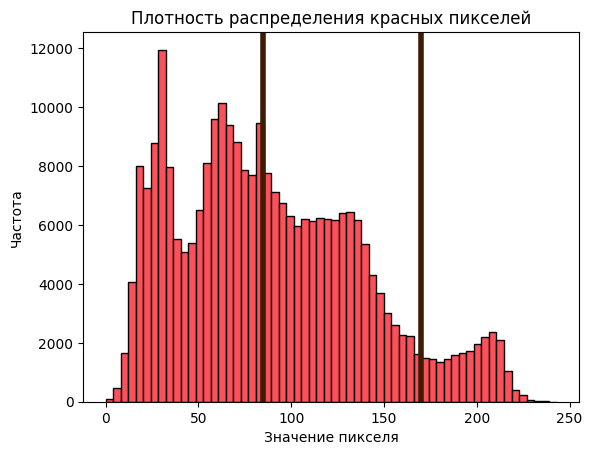

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(df_rgb["R"].values, color='#fc505a', edgecolor = 'black', bins = int(180/3))

plt.axvline(x=85, color='#3d1c02', linewidth=4)
plt.axvline(x=170, color='#3d1c02', linewidth=4)

# seaborn histogram
# sns.distplot(df_rgb["R"].values, hist=True, color='#fc505a', kde=False, hist_kws={'edgecolor':'black'},
#              bins=int(180/5))
# Add labels
plt.title('Плотность распределения красных пикселей')
plt.xlabel('Значение пикселя')
plt.ylabel('Частота')



In [46]:
print(df_rgb["R"].count())
print(df_rgb[df_rgb["R"]<86]["R"].count() / df_rgb["R"].count())
print(df_rgb[(df_rgb["R"]>86) & (df_rgb["R"]<170)]["R"].count() / df_rgb["R"].count())
print(df_rgb[df_rgb["R"]>170]["R"].count() / df_rgb["R"].count())

273612
0.525360729792553
0.38924827858427263
0.07667426867242665
